In [1]:
import torch 
torch.__version__

'1.13.0'

In [3]:
import torch 
torch.backends.mps.is_available()

True

In [4]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

device

'mps'

In [6]:
tensor = torch.tensor([1,2,3])# by default this exists on the cpu , we need to send it to the gpu 
print(tensor,tensor.device)
tensor_on_gpu = tensor.to(device)
print(tensor_on_gpu, tensor_on_gpu.device)

tensor

tensor([1, 2, 3]) cpu
tensor([1, 2, 3], device='mps:0') mps:0


tensor([1, 2, 3])

In [8]:
#now we can see that the since that the  numpy is on the gpu , since the computation is done on cpu and not on the gpu , this will lead to an error 
tensor_on_gpu.numpy()



TypeError: can't convert mps:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [12]:
#now lets send the tensor on gpu to the cpu 
tensor_on_cpu = tensor_on_gpu.cpu()

print(tensor_on_cpu.device)

cpu


In [17]:
import random 
random_tensor = torch.rand(7,7)

print(random_tensor)

#now lets create a view of the numpy array

z= random_tensor.view(1,49)
print(z.shape)

tensor([[0.3950, 0.4549, 0.8235, 0.4352, 0.3722, 0.0297, 0.2472],
        [0.0298, 0.4832, 0.9539, 0.3452, 0.0529, 0.6992, 0.6587],
        [0.3990, 0.5580, 0.8735, 0.8691, 0.7384, 0.5120, 0.1090],
        [0.6257, 0.0635, 0.6094, 0.1310, 0.5773, 0.5507, 0.3645],
        [0.9897, 0.8829, 0.2612, 0.6100, 0.8672, 0.8960, 0.6690],
        [0.0626, 0.8196, 0.5329, 0.0824, 0.9255, 0.2051, 0.1434],
        [0.3835, 0.6640, 0.7996, 0.1196, 0.1255, 0.3602, 0.2206]])
torch.Size([1, 49])


In [18]:
if torch.accelerator.is_available():
    tensor=tensor.to(torch.accelerator.current_accelerator())

AttributeError: module 'torch' has no attribute 'accelerator'

In [7]:
import torch
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X= torch.arange(0,1,0.02).unsqueeze(dim=1)

y= weight*X+ bias

X[:10] , y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [8]:
#we now seperate the datasets into the train ,test and split.

train_split = int(0.8*len(X))

x_train, y_train=X[:train_split],y[:train_split]

x_test,y_test = X[train_split:],y[train_split:] 

print(len(x_train),len(x_test), len(y_train), len(y_test))

40 10 40 10


In [9]:
import torch 
import torch.nn as nn
import torch.optim
import torch.utils.data

class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, dtype=torch.float32, requires_grad=True))
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float32, requires_grad=True))
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias   # fixed "self.weight" typo to "self.weights"
    
# Set manual seed since nn.Parameter are randomly initialized
torch.manual_seed(42)

# Create an instance of the model
model_0 = LinearRegressionModel()

# Check parameters
print(list(model_0.parameters()))
model_0.state_dict()

[Parameter containing:
tensor([0.3367], requires_grad=True), Parameter containing:
tensor([0.1288], requires_grad=True)]


OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [10]:
with torch.inference_mode():
    y_preds = model_0(x_test)
    
    
#now lets see the predictions we get 
print(f"Number of the testing samples are  {len(x_test)}")

print(f"Number of training samples are {len(y_preds)}")

print(f"Predicted values are {y_preds}")

Number of the testing samples are  10
Number of training samples are 10
Predicted values are tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


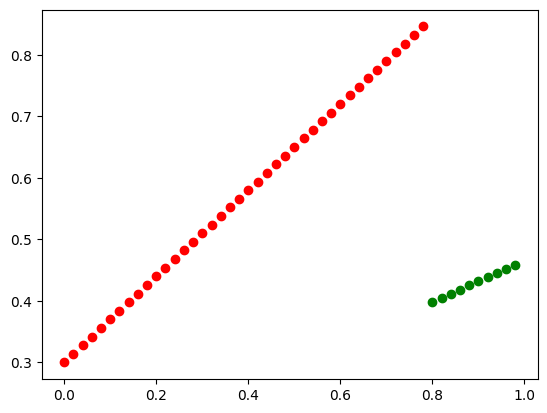

In [12]:
import matplotlib.pyplot as plt 

plt.scatter(x_train,y_train , color="red")

plt.scatter(x_test,y_preds , color="green")


In [13]:
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params = model_0.parameters(), lr=0.01)


In [16]:
#now since we see that the above weight and bias was  a random vector  ,we now want to train and then test the model 
#for this we will create the training loop 
torch.manual_seed(42)

epochs = 100

train_loss_values = []
test_loss_values = []

epoch_count = []

for epoch in range(epochs):
    model_0.train()
    #training means perform the forward pass  , 
    #after doing the forward pass , now we try to do the loss calculation 
    y_pred = model_0(x_train)
    loss = loss_fn(y_train , y_pred)
     #after calculating the loss , we now want to backpropagate 
    #firstly we zero the gradients 
    optimizer.zero_grad()
    #we perform the backpropagation 
    loss.backward()
    
    #perfom the optimizer step 
    optimizer.step()
    
    #then we put the model in the eval mode
    model_0.eval()
    
    #now we need to test the model 
    with torch.inference_mode():
        test_pred = model_0(x_test)
        test_loss = loss_fn(y_pred , y_test.type(torch.float32))
        if epoch% 10 ==0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            
            print(f"Epoch: {epoch} | MAE Train Loss : {loss} | MAE Test loss : {test_loss}")
        
    

RuntimeError: The size of tensor a (40) must match the size of tensor b (10) at non-singleton dimension 0

In [17]:
#now lets create a second version of the linear regression model 
class LinearRegressionModel_v2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features = 1 , out_features = 1)
        
    def forward(self, x):
        return self.linear_layer(x)
#this has created the model 
torch.manual_seed(42)

model_1 = LinearRegressionModel_v2()

model_1, model_1.state_dict()

(LinearRegressionModel_v2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [24]:
next(model_1.parameters()).device

device(type='cpu')

In [27]:
#the tensors are in cpu , we need to send them to gpu 
model_1.to("mps")
next(model_1.parameters()).device

device(type='mps', index=0)

In [30]:
#now we create the loss function 
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params = model_1.parameters(), lr = 0.01)
device= "mps"

In [31]:
#after setting the necessary loss and optimizer function , we need to now build the training loop 

torch.manual_seed(42)
epochs = 1000

#since the parameters of the model are in gpu , we need to ttransfer all the lists to gpu

x_train = x_train.to(device)
x_test = x_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    model_1.train()
    
    y_pred = model_1(x_train)
    
    loss = loss_fn(y_pred , y_train )
    
    optimizer.zero_grad()
    
    loss.backward()
    
    model_1.eval()
    with torch.inference_mode():
        y_preds = model_1(x_test)
        
        test_loss  = loss_fn(y_test,y_pred)
        
    if epoch%100 ==0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")
        

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/autograd/__init__.py:197: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (10) must match the size of tensor b (40) at non-singleton dimension 0